In [ ]:
try:
    import firedrake
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/firedrake-install-release-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
    import firedrake

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from firedrake import *
import matplotlib.pyplot as plt
import numpy as np

from firedrake.petsc import PETSc

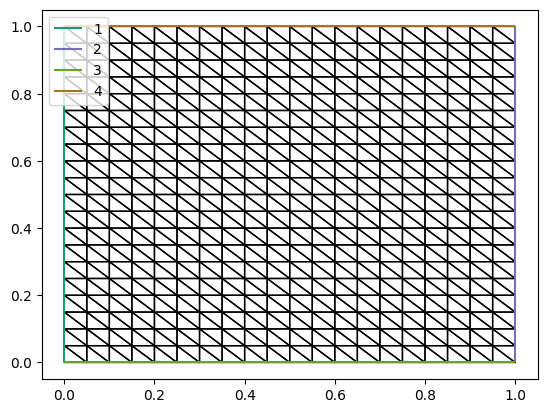

In [ ]:
n = 20  # per unit length
mesh = UnitSquareMesh(n, n)
fig, ax = plt.subplots()
triplot(mesh, axes=ax)
ax.legend(loc='upper left')

In [ ]:
V=VectorFunctionSpace(mesh,'P',2)
Q=FunctionSpace(mesh,'P',1)
W=MixedFunctionSpace([V,Q])

x=SpatialCoordinate(mesh)
t_=Constant(0)

u_1=as_vector((-sin(x[1])*sin(t_),\
               0))

u_2=as_vector((-cos(1)*sin(x[1])*sin(t_),\
               sin(1)*cos(x[1])*sin(t_)))

u_4=as_vector((-cos(x[0])*sin(1)*sin(t_),\
               sin(x[0])*cos(1)*sin(t_)))

bc_1=DirichletBC(W.sub(0),u_1,1)
bc_2=DirichletBC(W.sub(0),u_2,2)
bc_4=DirichletBC(W.sub(0),u_4,4)
bcsU=(bc_1,bc_2,bc_4)
nu=0.01
p_ex=-1/4*(cos(2*x[0])+cos(2*x[1]))*sin(t_)**2

h=as_vector((nu*cos(x[0])*sin(t_),p_ex))

f_ex=as_vector((-cos(x[0])*sin(x[1])*(cos(t_)+2*nu*sin(t_)),\
                sin(x[0])*cos(x[1])*(cos(t_)+2*nu*sin(t_))))

dt=1/16
T=1

u_ex=as_vector((-cos(x[0])*sin(x[1])*sin(t_),\
                sin(x[0])*cos(x[1])*sin(t_)))

In [ ]:
def cn_newton(u,v,p,q,u_old,nu,dt,f,f_old,h,p_old):
  a=1/dt*inner(u,v)*dx\
    +1/2*nu*inner(grad(u),grad(v))*dx\
    +1/2*dot(dot(grad(u_old),u),v)*dx\
    +1/2*dot(dot(grad(u),u_old),v)*dx\
    -1/2*p*div(v)*dx\
    +q*div(u)*dx
  L=1/dt*inner(u_old,v)*dx\
     -1/2*nu*inner(grad(u_old),grad(v))*dx\
     -1/2*dot(grad(p_old),v)*dx\
     +1/2*dot(f+f_old,v)*dx\
     +2*dot(h,v)*ds(3)
  return a,L


def snes_solver(u,v,p,q,u_old,nu,dt,f,f_old,h,p_old):
  G=1/dt*inner(u,v)*dx\
    +1/2*nu*inner(grad(u),grad(v))*dx\
    +1/2*dot(dot(grad((u+u_old)/2),(u+u_old)/2),v)*dx\
    -1/2*p*div(v)*dx\
    +q*div(u)*dx\
    -1/dt*inner(u_old,v)*dx\
     +1/2*nu*inner(grad(u_old),grad(v))*dx\
     +1/2*dot(grad(p_old),v)*dx\
     -1/2*dot(f+f_old,v)*dx\
     -2*dot(h,v)*ds(3)
  return G


def bdf2(u,v,p,q,u_old,nu,dt,f_ex,h,u_oldold):
  a=1/dt*3/2*inner(u,v)*dx\
    +nu*inner(grad(u),grad(v))*dx\
    +dot(dot(grad(u),(2*u_old-u_oldold)),v)*dx\
    -p*div(v)*dx\
    +q*div(u)*dx
  L=dot(f_ex,v)*dx\
     +1/dt*2*dot(u_old,v)*dx\
     -1/dt*1/2*dot(u_oldold,v)*dx\
     +dot(h,v)*ds(3)
  return a,L

In [ ]:
param = ( {'snes_type':'newtonls', # nonlinear solver types: https://petsc.org/release/manual/snes/#the-nonlinear-solvers
       'snes_monitor':'',        # activate logging options
       'snes_monitoring_lg_residualnorm':'', # print ||G|| at each iteration
       'snes_rtol':1e-6, 'snes_atol':1e-10, 'snes_stol':1e-14, 'snes_maxit':1000
       })

In [ ]:
u,p=TrialFunctions(W)
v,q=TestFunctions(W)

wh=Function(W)
uh,ph=wh.subfunctions

uh.interpolate(u_ex)
ph.interpolate(p_ex)

uh_old=Function(V)
ph_old=Function(Q)

uh_old.assign(uh)
ph_old.assign(ph)

f=Function(V)
f.interpolate(f_ex)

f_old=Function(V)
f_old.interpolate(f_ex)

a,L=cn_newton(u,v,p,q,uh_old,nu,dt,f,f_old,h,ph_old)
problem=LinearVariationalProblem(a,L,wh,bcsU)
solver=LinearVariationalSolver(problem)

"""
wh_snes=Function(W)
uh_snes,ph_snes=split(wh_snes)
uh_old=Function(V)
ph_old=Function(Q)
uh_old.assign(wh_snes.sub(0))
ph_old.assign(wh_snes.sub(1))
dwh=TrialFunction(W)
G=snes_solver(uh_snes,v,ph_snes,q,uh_old,nu,dt,f,f_old,h,ph_old)
J=derivative(G,wh_snes,dwh)
A=NonlinearVariationalProblem(G,wh_snes,bcsU,J)
solver_snes=NonlinearVariationalSolver(A,solver_parameters=param)"""


'\nwh_snes=Function(W)\nuh_snes,ph_snes=split(wh_snes)\nuh_old=Function(V)\nph_old=Function(Q)\nuh_old.assign(wh_snes.sub(0))\nph_old.assign(wh_snes.sub(1))\ndwh=TrialFunction(W)\nG=snes_solver(uh_snes,v,ph_snes,q,uh_old,nu,dt,f,f_old,h,ph_old)\nJ=derivative(G,wh_snes,dwh)\nA=NonlinearVariationalProblem(G,wh_snes,bcsU,J)\nsolver_snes=NonlinearVariationalSolver(A,solver_parameters=param)'

In [ ]:
"""t_vec = np.arange(0, 2*dt, dt)  # T+0.1*dt to include also T: range/arange exclude the upper bound of the range


for ii in range(1, len(t_vec)):     # start from 1 to skip t=0
    t_val = t_vec[ii]
    print('Time = ', t_val)
    f_old.interpolate(f_ex)
    t_.assign(t_val)
    f.interpolate(f_ex)
    a,L=cn_newton(u,v,p,q,uh_old,nu,dt,f,f_old,h,ph_old)
    problem=LinearVariationalProblem(a,L,wh,bcsU)
    solver=LinearVariationalSolver(problem)
    solver.solve()
    print('||u||_{H^1} =', norm(uh,'H1'))
    uh_old.assign(uh)
    ph_old.assign(ph)"""

"t_vec = np.arange(0, 2*dt, dt)  # T+0.1*dt to include also T: range/arange exclude the upper bound of the range\n\n\nfor ii in range(1, len(t_vec)):     # start from 1 to skip t=0\n    t_val = t_vec[ii]\n    print('Time = ', t_val)\n    f_old.interpolate(f_ex)\n    t_.assign(t_val)\n    f.interpolate(f_ex)\n    a,L=cn_newton(u,v,p,q,uh_old,nu,dt,f,f_old,h,ph_old)\n    problem=LinearVariationalProblem(a,L,wh,bcsU)\n    solver=LinearVariationalSolver(problem)\n    solver.solve()\n    print('||u||_{H^1} =', norm(uh,'H1'))\n    uh_old.assign(uh)\n    ph_old.assign(ph)"

In [ ]:
"""uh_oldold_bdf=Function(V)
uh_old_bdf=Function(V)

uh_oldold_bdf.interpolate(u_ex)
uh_old_bdf.assign(uh_old)
wh_bdf=Function(W)
uh_bdf,ph_bdf=wh_bdf.subfunctions

ph_old_bdf=Function(Q)
ph_old_bdf.assign(ph_old)

a_bdf,L_bdf=bdf2(u,v,p,q,uh_old_bdf,nu,dt,f_ex,h,uh_oldold_bdf)
problem_bdf=LinearVariationalProblem(a_bdf,L_bdf,wh,bcsU)
solver_bdf=LinearVariationalSolver(problem_bdf)
#solver_bdf.solve()"""

'uh_oldold_bdf=Function(V)\nuh_old_bdf=Function(V)\n\nuh_oldold_bdf.interpolate(u_ex)\nuh_old_bdf.assign(uh_old)\nwh_bdf=Function(W)\nuh_bdf,ph_bdf=wh_bdf.subfunctions\n\nph_old_bdf=Function(Q)\nph_old_bdf.assign(ph_old)\n\na_bdf,L_bdf=bdf2(u,v,p,q,uh_old_bdf,nu,dt,f_ex,h,uh_oldold_bdf)\nproblem_bdf=LinearVariationalProblem(a_bdf,L_bdf,wh,bcsU)\nsolver_bdf=LinearVariationalSolver(problem_bdf)\n#solver_bdf.solve()'

In [ ]:
t_vec = np.arange(0, T+0.1*dt, dt)  # T+0.1*dt to include also T: range/arange exclude the upper bound of the range
err_u_LinfL2=[0]*len(t_vec)
err_u_LinfH1=[0]*len(t_vec)
err_p_LinfL2=[0]*len(t_vec)

for ii in range(1, len(t_vec)):     # start from 1 to skip t=0
    t_val = t_vec[ii]
    print('Time = ', t_val)

    f_old.interpolate(f_ex)

    t_.assign(t_val)
    f.interpolate(f_ex)
    a,L=cn_newton(u,v,p,q,uh_old,nu,dt,f,f_old,h,ph_old)
    problem=LinearVariationalProblem(a,L,wh,bcsU)
    solver=LinearVariationalSolver(problem)
    solver.solve()
    uh,ph=wh.subfunctions
    print('||u||_{H^1} =', norm(uh,'H1'))
    #uh_oldold_bdf.assign(uh_old_bdf)
    #uh_old_bdf.assign(uh_bdf)
    #ph_old_bdf.assign(ph_bdf)
    uh_old.assign(uh)
    ph_old.assign(ph)

    err_u_LinfL2[ii] = max(err_u_LinfL2[ii], errornorm(u_ex, uh, 'L2'))
    err_u_LinfH1[ii] = max(err_u_LinfH1[ii], errornorm(u_ex, uh, 'H1'))
            # For p, to correctly observe convergence we know that a correction is required in the fully Dirichlet case: see Lab 2.
    mean_ph = assemble(ph*dx)
    mean_p_ex = assemble(p_ex*dx)
    err_p_LinfL2[ii] = sqrt(assemble((ph-mean_ph - (p_ex-mean_p_ex))*(ph-mean_ph - (p_ex-mean_p_ex))*dx))

Time =  0.0625
||u||_{H^1} = 0.08199225002976827
Time =  0.125
||u||_{H^1} = 0.1618931420817866
Time =  0.1875
||u||_{H^1} = 0.24259847971928322
Time =  0.25
||u||_{H^1} = 0.32236307287278676
Time =  0.3125
||u||_{H^1} = 0.40225368438494885
Time =  0.375
||u||_{H^1} = 0.48210845708107797
Time =  0.4375
||u||_{H^1} = 0.5630777969829899
Time =  0.5
||u||_{H^1} = 0.6459950861095796
Time =  0.5625
||u||_{H^1} = 0.7324855980609584
Time =  0.625
||u||_{H^1} = 0.8241520497674234
Time =  0.6875
||u||_{H^1} = 0.9230153452299784
Time =  0.75
||u||_{H^1} = 1.0309985224424754
Time =  0.8125
||u||_{H^1} = 1.1500084487956899
Time =  0.875
||u||_{H^1} = 1.2815586211945174
Time =  0.9375
||u||_{H^1} = 1.4267123469817626
Time =  1.0
||u||_{H^1} = 1.5858462002210398


Text(0.5, 1.0, 'velocity')

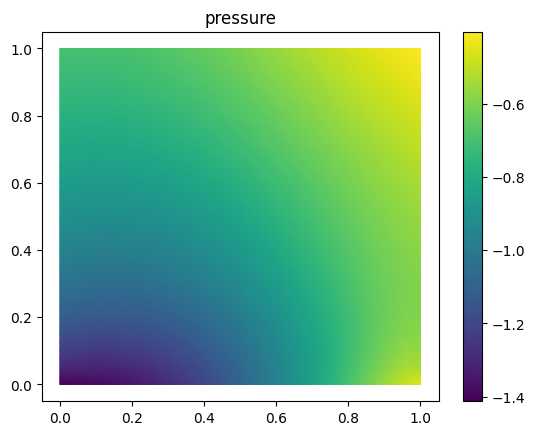

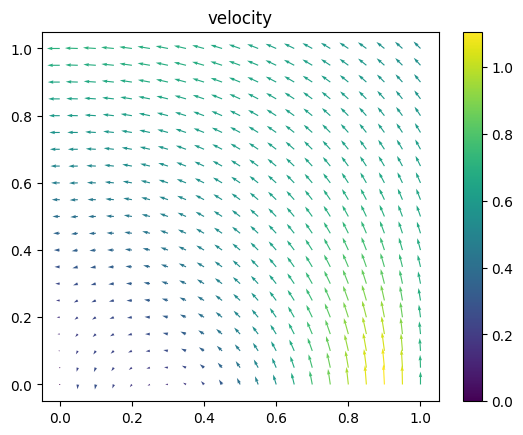

In [ ]:
fig, ax = plt.subplots()
col = tripcolor(ph, axes=ax)
plt.colorbar(col)
plt.title('pressure')
fig, ax = plt.subplots()
col = quiver( uh, axes=ax)
plt.colorbar(col)
plt.title('velocity')

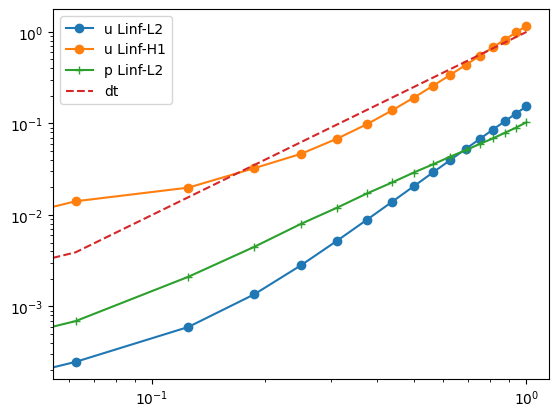

In [ ]:
plt.loglog(t_vec, err_u_LinfL2, marker='o', label='u Linf-L2')
plt.loglog(t_vec, err_u_LinfH1, marker='o', label='u Linf-H1')
plt.loglog(t_vec, err_p_LinfL2, marker='+', label='p Linf-L2')
plt.loglog(t_vec, t_vec**2, linestyle='--', label='dt')

plt.legend()

In [ ]:
err_u_LinfL2=np.array(err_u_LinfL2)[-1]
err_u_LinfH1=np.array(err_u_LinfH1)[-1]
err_p_LinfL2=np.array(err_p_LinfL2)[-1]
print(np.shape(err_u_LinfL2))
print('err_u_LinfL2 =', err_u_LinfL2)
print('err_u_LinfH1 =', err_u_LinfH1)
print('err_p_LinfL2 =', err_p_LinfL2)

()
err_u_LinfL2 = 0.15367211387115934
err_u_LinfH1 = 1.1643275818360015
err_p_LinfL2 = 0.10316832632856575


In [ ]:
#betaL2u =  np.log(err_u_LinfH1[2:]/err_u_LinfH1[1:-1])/np.log(0.5)
#betaH1u = np.log(err_p_LinfL2[2:]/err_p_LinfL2[1:-1])/np.log(0.5)

#print(betaL2u,betaH1u)

In [ ]:
err_u_LinfH1=np.array([0.189,0.144,0.1273,0.120])
err_p_LinfL2=np.array([0.0734,0.0565,0.0485,0.0446])

betaL2u = np.log(err_u_LinfH1[1:]/err_u_LinfH1[:-1])/np.log(0.5)
betaH1u = np.log(err_p_LinfL2[1:]/err_p_LinfL2[:-1])/np.log(0.5)

print(betaL2u,betaH1u)

[0.39231742 0.17783639 0.08519801] [0.3775292  0.22026612 0.12094104]
